### Multi-Class Classification

In this notebook we will use multiple models for our classification.

We will be using the *Dry Bean* [dataset from UCI](https://archive.ics.uci.edu/dataset/602/dry+bean+dataset).

The steps are as follows:
1. Exploration
   - [Loading](#load)
   - [Cleaning](#clean)
   - [Visualizing](#visual)
2. Modeling
   - [KNN](knnmodel)
   - [XGBoost](#xgbmodel)
   - [TensorFlow](#tfmodel)
   - [PyTorch](#torchmodel)
3. [Summary](#summary)

In [18]:
## first the imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')


## ML packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import tensorflow.keras as keras

## setting the random seed for reproducibility
import random
RANDOM_SEED = 60
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

<a name='load'></a>
### loading the data

In [7]:
data = pd.read_csv('https://archive.ics.uci.edu/static/public/602/data.csv')
data.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRatio      13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  Roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

<a name='clean'></a>
### Cleaning the data

In [9]:
def data_cleaner(df):
    df.columns = [x.replace(r'\s+', '_').lower() for x in df.columns]
    type_dict = {}
    for col in df.columns:
        if df[col].dtype == 'float64' and df[col].min() == df.astype({col:'float16'})[col].min():
            type_dict[col] = 'float16'
        elif df[col].dtype == 'float64' and df[col].min() == df.astype({col:'float32'})[col].min():
            type_dict[col] = 'float32'
        elif df[col].dtype == 'int64' and df[col].min() == df.astype({col:'int16'})[col].min():
            type_dict[col] = 'int16'
        elif df[col].dtype == 'int64' and df[col].min() == df.astype({col:'int32'})[col].min():
            type_dict[col] = 'int32'
        elif df[col].dtype == 'object' and df[col].nunique() < 5:
            df = pd.get_dummies(data=df, columns=[col])

    return df.astype(type_dict)

cleaned_data = data_cleaner(data.copy())
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area             13611 non-null  int32  
 1   perimeter        13611 non-null  float64
 2   majoraxislength  13611 non-null  float64
 3   minoraxislength  13611 non-null  float64
 4   aspectratio      13611 non-null  float64
 5   eccentricity     13611 non-null  float64
 6   convexarea       13611 non-null  int32  
 7   equivdiameter    13611 non-null  float64
 8   extent           13611 non-null  float64
 9   solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  compactness      13611 non-null  float64
 12  shapefactor1     13611 non-null  float64
 13  shapefactor2     13611 non-null  float64
 14  shapefactor3     13611 non-null  float64
 15  shapefactor4     13611 non-null  float64
 16  class            13611 non-null  object 
dtypes: float64(1

<a name='visual'></a>
### visualizing the distribution for the classes

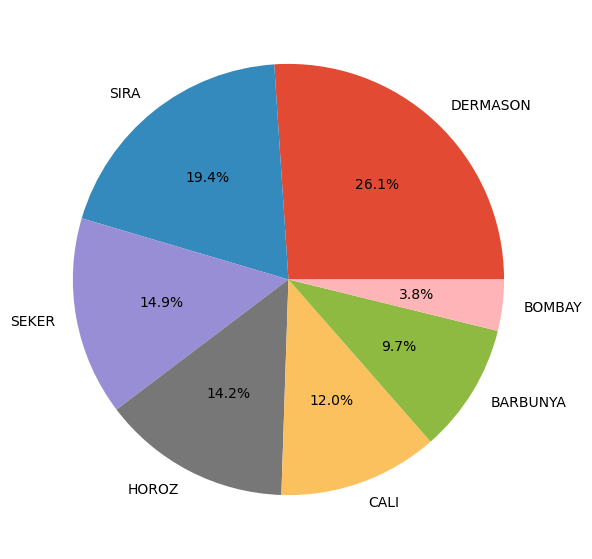

In [10]:
## getting the values for each class
values = cleaned_data['class'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(values.values, labels = values.index,
       autopct='%1.1f%%');

Two of the classes seem to be lacking the same number of instances as the rest, we might have to consider that when we're splitting the data.

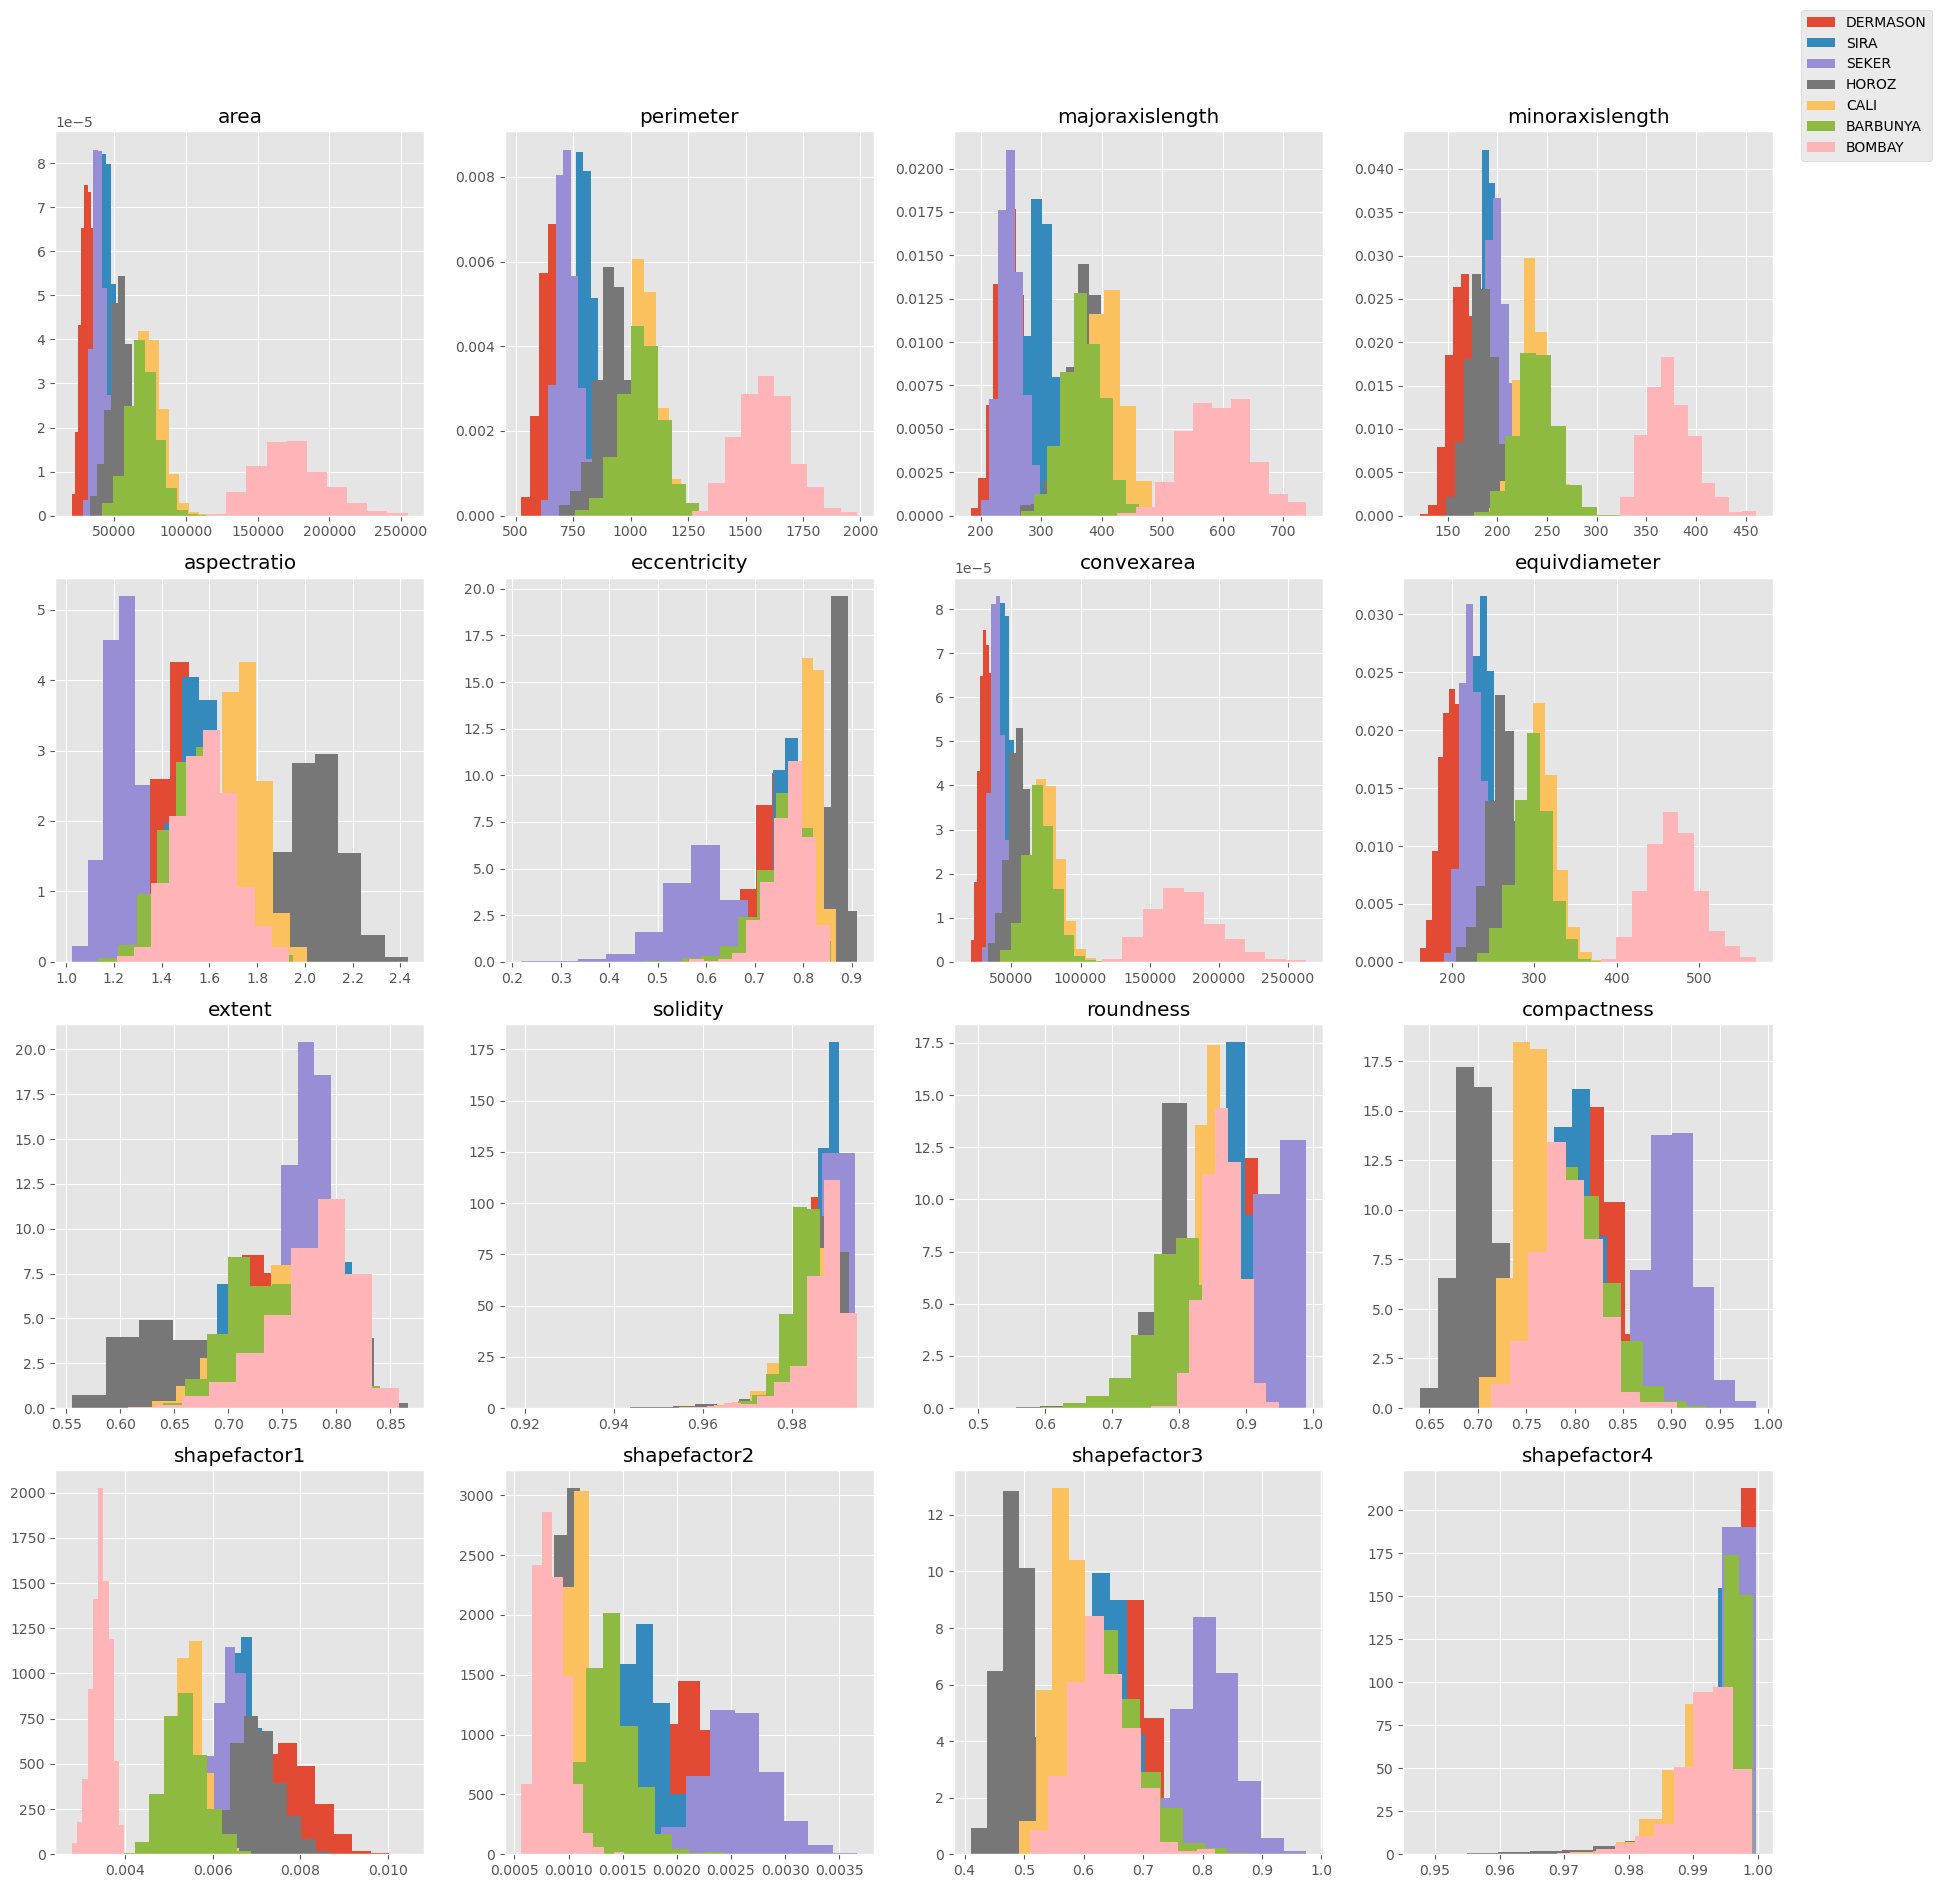

In [11]:
## checking the dist for each variable
nrows, ncols = 4, 4 
plt.figure(figsize = (18, 18))
c = 1
for col in cleaned_data.drop('class', axis=1).columns:
    for type in values.index:
        plt.subplot(nrows, ncols, c)
        plt.hist(cleaned_data[cleaned_data['class'] ==type][col], 
                 density=True, label=type)
        plt.title(col)
        
    c+=1
handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels, bbox_to_anchor=(1.08, 1.05))
plt.tight_layout();

* We can see that *BOMBAY* class has different distributions for most of the features.

* One of the other observations can be that `solidity` and `shapeFactor4` could be removed from our features, since the distribution for all of the classes are practically the same and they won't be adding any additional information in terms of classification.

<a id='startingwmodel'></a>
### Starting with the Model

In [50]:
## we need to convert our classes into usable labels for our model
X, y = cleaned_data.drop(['class', 'solidity', 'shapefactor4'], axis=1), pd.get_dummies(cleaned_data['class'], dtype='int8')
X.shape, y.shape

((13611, 14), (13611, 7))

In [51]:
## and then we have to break our datasets into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, 
                                                   stratify=y, random_state=RANDOM_SEED)
## we need to also scale our features
scaler = StandardScaler()
scaler.fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10888, 14), (10888, 7), (2723, 14), (2723, 7))

<a name='knnmodel'></a>
### KNN Model

In [25]:
## creating our model
knn_pipe = Pipeline([('knn',KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)
print(f'The basic model score {knn_pipe.score(X_test, y_test)*100:.2f}%')
knn_pipe.get_params()

The basic model score 90.75%


{'memory': None,
 'steps': [('knn', KNeighborsClassifier())],
 'verbose': False,
 'knn': KNeighborsClassifier(),
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [24]:
## cross-validation
params = {'knn__leaf_size':[15, 20, 30, 40],
         'knn__n_jobs':[None, 2, 4],
         'knn__n_neighbors':[3, 5, 8]}
cv = GridSearchCV(knn_pipe,
                 param_grid=params,
                 cv = 3)
cv.fit(X_train, y_train)
best_model = cv.best_estimator_
print(f'The best model after cross-validation {best_model.score(X_test, y_test)*100:.2f}%')
best_model

The best model after cross-validation 90.75%


Pipeline(steps=[('knn', KNeighborsClassifier(leaf_size=15))])

In [26]:
## cross-validation
params = {'knn__leaf_size':[5,10,15]}
cv = GridSearchCV(knn_pipe,
                 param_grid=params,
                 cv = 3)
cv.fit(X_train, y_train)
best_model2 = cv.best_estimator_
print(f'The best model after second cross-validation {best_model2.score(X_test, y_test)*100:.2f}%')
best_model2

The best model after second cross-validation 90.75%


Pipeline(steps=[('knn', KNeighborsClassifier(leaf_size=5))])

In [28]:
## the classification report
preds = best_model2.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       265
           1       1.00      1.00      1.00       104
           2       0.90      0.94      0.92       326
           3       0.91      0.91      0.91       709
           4       0.97      0.92      0.95       386
           5       0.97      0.93      0.95       406
           6       0.84      0.86      0.85       527

   micro avg       0.92      0.91      0.91      2723
   macro avg       0.93      0.92      0.92      2723
weighted avg       0.92      0.91      0.91      2723
 samples avg       0.91      0.91      0.91      2723



<a name='xgbmodel'></a>
### XGBoost Classifier Model

In [10]:
## next we have to start with our model
cl = XGBClassifier()
cl.fit(X_train, y_train)
print(f'The Model Score : {round(cl.score(X_test, y_test)*100, 2)}%')

The Model Score : 90.27%


In [11]:
y_preds = cl.predict(X_test)
print(y_test.columns.tolist())
print(classification_report(y_test, y_preds))

['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       265
           1       0.98      1.00      0.99       104
           2       0.90      0.94      0.92       326
           3       0.91      0.92      0.91       709
           4       0.98      0.92      0.95       386
           5       0.96      0.94      0.95       406
           6       0.88      0.85      0.87       527

   micro avg       0.93      0.91      0.92      2723
   macro avg       0.94      0.92      0.93      2723
weighted avg       0.93      0.91      0.92      2723
 samples avg       0.91      0.91      0.91      2723



C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a name='tfmodel'></a>
### Testing with TensorFlow

In [14]:
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
X_train, X_test = torch.from_numpy(X_train).type(torch.float32), torch.from_numpy(X_test).type(torch.float32)
y_train, y_test = torch.from_numpy(y_train).type(torch.float32),torch.from_numpy(y_test).type(torch.float32)

In [31]:
seq_keras_model = keras.Sequential([
    keras.Input(shape = (X_train.shape[1],)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(y_train.shape[1], activation='softmax')
])

seq_keras_model.compile(optimizer='adam', loss = 'MSE')

epochs = 50
batch_size = 32
seq_keras_model.fit(X_train, y_train, batch_size= batch_size, epochs=epochs, verbose=1)
print(f'The loss for test evaluation: {seq_keras_model.evaluate(X_test,y_test):.3f}')

Epoch 1/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0532
Epoch 2/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0193
Epoch 3/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0193
Epoch 4/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0192
Epoch 5/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0176
Epoch 6/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0181
Epoch 7/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0176
Epoch 8/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0171
Epoch 9/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0174
Epoch 10/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0167
Epoch 11/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0169
Epoch 12/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0174
Epoch 13/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0166
Epoch 14/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0174
Epoch 15/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [33]:
preds = seq_keras_model.predict(X_test)
print(classification_report(y_test.argmax(1), preds.argmax(1)))

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.89      0.93       265
           1       1.00      1.00      1.00       104
           2       0.90      0.96      0.93       326
           3       0.92      0.91      0.91       709
           4       0.98      0.92      0.95       386
           5       0.98      0.93      0.95       406
           6       0.84      0.91      0.87       527

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



<a name='torchmodel'></a>
### Testing with `torch.nn`

In [52]:
## we have to convert our data into tensors
## our features are already in np array format
## but we have to convert our labels
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
X_train, X_test = torch.from_numpy(X_train).type(torch.float32), torch.from_numpy(X_test).type(torch.float32)
y_train, y_test = torch.from_numpy(y_train).type(torch.float32),torch.from_numpy(y_test).type(torch.float32)

In [42]:
## we will be using a simple model for our example
hidden_units = 8
learning_rate = 1e2
seq_model = nn.Sequential(
    nn.Linear(in_features=X_train.shape[1], out_features=hidden_units),
    # nn.Linear(in_features=hidden_units, out_features=hidden_units),
    nn.ReLU(),
    nn.Linear(in_features=hidden_units, out_features=y_train.shape[1])
)
## and for our loss we'll use the cross entropy
## which takes the raw logits, se we don't need softmax here
loss_fn = nn.CrossEntropyLoss()
## and Adam as our optimizer
optimizer = torch.optim.Adam(params = seq_model.parameters(),
                            lr=learning_rate)
seq_model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1739, -0.2397, -0.1570,  0.1876, -0.1942,  0.1863, -0.2038,  0.1517,
                       -0.0298,  0.2239, -0.0720, -0.1762, -0.2596, -0.0653],
                      [ 0.0836,  0.2363,  0.2646, -0.1793,  0.1724, -0.2582,  0.0466,  0.0255,
                       -0.2086, -0.2483, -0.0701, -0.0692, -0.0871, -0.1316],
                      [ 0.0704,  0.0024,  0.2431,  0.0164, -0.2334,  0.0200, -0.2631, -0.1544,
                        0.1863, -0.1577, -0.1596,  0.1263, -0.0703,  0.0052],
                      [ 0.2202,  0.0444, -0.2039,  0.0355,  0.1400,  0.0653, -0.2341, -0.0779,
                       -0.0396, -0.0834, -0.1629, -0.0130, -0.2038, -0.0589],
                      [-0.1025, -0.1460,  0.0286,  0.0947, -0.2484,  0.1067, -0.2007,  0.1153,
                        0.0783, -0.2368,  0.2356,  0.0049, -0.1697,  0.0412],
                      [ 0.1476,  0.0053, -0.1852, -0.1385,  0.0379,  0.1940,  0.1978,  0.0738,
              

In [53]:
## next is the training loop
epochs = 5000
loss_dict = {}
for e in range(epochs):
    ## first we have to calculate the predictions
    preds = seq_model(X_train)
    ## then calculate the loss
    loss = loss_fn(preds, y_train)
    ## then zero out the grads
    optimizer.zero_grad()
    ## and then run the backpropagation
    loss.backward()
    ## and finally, take a step
    optimizer.step()
    ## storing the loss values
    if e%500==0:
        print(f'Epoch {e} Current Training Loss : {loss:.3f}')
        loss_dict[e] = loss.item()

Epoch 0 Current Training Loss : 34.434
Epoch 500 Current Training Loss : 31.819
Epoch 1000 Current Training Loss : 33.543
Epoch 1500 Current Training Loss : 25.896
Epoch 2000 Current Training Loss : 38.987
Epoch 2500 Current Training Loss : 40.990
Epoch 3000 Current Training Loss : 26.629
Epoch 3500 Current Training Loss : 40.865
Epoch 4000 Current Training Loss : 18.310
Epoch 4500 Current Training Loss : 69.794


In [45]:
preds = seq_model(X_train)
print(classification_report(y_train.argmax(1), preds.argmax(1).detach()))

              precision    recall  f1-score   support

           0       0.10      1.00      0.18      1057
           1       1.00      1.00      1.00       418
           2       0.00      0.00      0.00      1304
           3       0.00      0.00      0.00      2837
           4       0.00      0.00      0.00      1542
           5       0.00      0.00      0.00      1621
           6       0.00      0.00      0.00      2109

    accuracy                           0.14     10888
   macro avg       0.16      0.29      0.17     10888
weighted avg       0.05      0.14      0.06     10888



<a name='summary'></a>
### Summary

- The best model performace was achieved by the **XGBoost Classifier** tied with **Keras linear Model**, with *F-1 Score* of `0.92`.
- The accuracy of the **KNN Classifier** after two rounds of cross-validation did not show any significant imporvemnets and stayed at `91%`.
